# Tutorial

This tutorial shows how to synthesize diffusion MRI data using Disimpy. You can follow the tutorial by executing the code in each shell in the order that they are presented here.

In [1]:
# Import packages and modules used in this tutorial

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from disimpy import gradients, meshes, simulations, utils

### Gradient arrays

First, we need to define a gradient array that contains the necessary information about the simulated diffusion-weighting magnetic field gradients. Gradient arrays are Numpy arrays with a shape of (number of measurements, number of time points, 3). The elements of gradient arrays are floating point numbers representing the gradient magnitude at that time point in SI units (T/m). The module disimpy.gradients contains several useful functions for creating and manipulating gradient arrays. In the example below, we define a gradient array to be used in this tutorial.

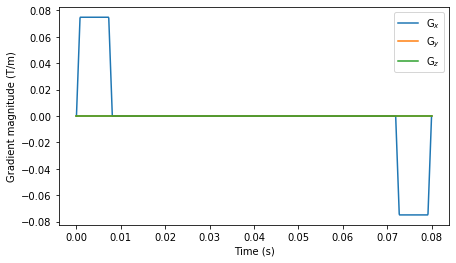

In [2]:
# Create a simple Stejskal-Tanner gradient waveform

gradient = np.zeros((1, 100, 3))
gradient[0, 1:10, 0] = 1
gradient[0, 90:99, 0] = -1
bs = np.linspace(1, 3e9, 100)  # Array of b-values in SI units (s/m^2)
gradient = np.concatenate([gradient for _ in bs], axis=0)


# Adjust gradient magnitude and number of time points

n_t = int(1e3 + 1)  # Number of time points in the simulation
T = 80e-3  # Duration of gradient array in seconds
dt = T / (gradient.shape[1] - 1)  # Duration of time step in gradient array
gradient, dt = gradients.interpolate_gradient(gradient, dt, n_t)
gradient = gradients.set_b(gradient, dt, bs)


# Show the gradient magnitude over time of the 50th measurement

fig, ax = plt.subplots(1, figsize=(7,4))
for i in range(3):
    ax.plot(np.linspace(0, T, n_t), gradient[50, :, i])
ax.legend(['G$_x$', 'G$_y$', 'G$_z$'])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Gradient magnitude (T/m)')
plt.show()

### Free diffusion

After defining the gradient array, we need to define the diffusion environment, referred to as substrate, using a substrate dictionary. Then, we can define the simulation parameters and execute the simulation like in the following example. 

Starting simulation.
Step length = 9.842399308377578e-07
Number of spins = 10000
Number of steps = 1000
Simulation finished.


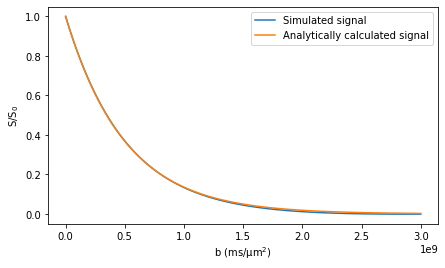

In [3]:
substrate = {'type' : 'free'}  # Substrate dictionary for free diffusion
n_s = int(1e4)  # Number of random walkers
diffusivity = 2e-9  # In SI units (m^2/s)


# Execute simulation

signals = simulations.simulation(n_s, diffusivity, gradient, dt, substrate)


# Plot the simulated signal decay and the analytically calculated signal decay

fig, ax = plt.subplots(1, figsize=(7,4))
ax.plot(bs, signals / n_s)
ax.plot(bs, np.exp(-bs * diffusivity))
ax.legend(['Simulated signal', 'Analytically calculated signal'])
ax.set_xlabel('b (ms/μm$^2$)')
ax.set_ylabel('S/S$_0$')
plt.show()

### Saving random walker trajectories

The trajectories of the random walkers can be saved by defining the path to the file in which the trajectories will be saved. The resulting file can be very large so the following example uses a small number of random walkers.

Starting simulation.
The trajectories file will be up to 0.00075075 GB
Step length = 9.842399308377578e-07
Number of spins = 10
Number of steps = 1000
Simulation finished.


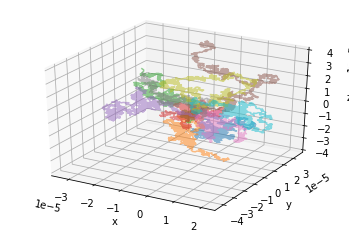

In [4]:
n_s = int(1e1)

signals = simulations.simulation(n_s, diffusivity, gradient, dt, substrate,
                                 trajectories='example_traj.txt')


# The trajectories can be quickly visualized using the following function

utils.show_traj('example_traj.txt')

### Restricted diffusion

Restricted diffusion can be simulated by defining the substrate dictionary that contains the required information. Currently, Disimpy supports restricted diffusion inside spheres, ellipsoids, infinite cylinders, and triangular meshes. The following code snippets show how to define the substrate dictionaries for each supported type of restricted diffusion.

Substrate dictionary for diffusion inside a sphere is simply:

In [5]:
substrate = {'type' : 'sphere',
             'radius' : 5e-6}  # In SI units (m)

Diffusion inside an ellipsoid requires the definition of the semi-axes of the ellipsoid (a, b, c) and the rotation matrix R that specifies how to rotate the axis-aligned ellipsoid prior to the simulation. Prior to the rotation, the semi-axes a, b, and c are aligned with the Cartesian coordinate axes x, y, and z, respectively. For example, the following substrate dictionary defines diffusion inside an ellipsoid with semi-axis lengths 10, 3, and 3 μm and with an orientation so that the longest semi-axis is aligned with vector (1, 1, 0).

In [6]:
v = np.array([1, 0, 0])  # Initial orientation of semiaxis a
k = np.array([1, 1, 1])  # Desired orientation of semiaxis a
R = utils.vec2vec_rotmat(v, k)  # Calculate rotation matrix

substrate = {'type' : 'ellipsoid',
             'a' : 10e-6,  # In SI units (m)
             'b' : 3e-6,  # In SI units (m)
             'c' : 3e-6,  # In SI units (m)
             'R' : R}

Simulating diffusion inside an infinite cylinder requires specifying the radius and the orientation of the cylinder like in the following example.

In [7]:
substrate = {'type' : 'cylinder',
             'orientation' : np.array([0, 0, 1]),
             'radius' : 5e-6}  # In SI units (m)

Diffusion inside arbitrary geometries can be simulated using triangular meshes. Disimpy supports triangular meshes represented by numpy.ndarray instances of shape (number of triangles, 3, 3) where the second dimension indices correspond to different triangle points and the third dimension indices correspond to the Cartesian coordinates of the points of the triangle. A simple function for loading triangular meshes in .ply format is also provided. The simulated voxel size is equal to the axis aligned bounding box of the triangles. The boundaries of the voxel are treated as hard surfaces that the random walkers can't cross. If the triangular mesh defines a closed surface, the initial positions of the random walkers can be uniformly distributed in the inside or outside space by controlling the parameters 'intra' and 'extra' in the substrate dictionary. The example below shows how to load and visualize a mesh, and how to perform a diffusion simulation in the environment defined by the mesh.

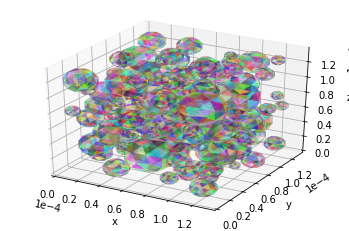

In [8]:
# Load and visualize an example mesh from disimpy/tests

mesh_path = os.path.join(os.path.dirname(meshes.__file__),
                         'tests', 'example_mesh.ply')
mesh = meshes.load_mesh(mesh_path)

meshes.show_mesh(mesh)  # It may take a while to render 10^4 triangles

Starting simulation.
The trajectories file will be up to 0.075075 GB
Step length = 9.842399308377578e-07
Number of spins = 1000
Number of steps = 1000
Finished calculating initial positions.
Simulation finished.


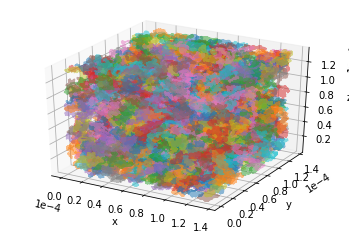

In [9]:
# Define substrate dictionary, run simulation, and show trajectories

substrate = {'type' : 'mesh',
             'mesh' : mesh,
             'extra' : True}  # Place spins only outside the mesh

n_s = int(1e3)
signals = simulations.simulation(n_s, diffusivity, gradient, dt, substrate,
                                 trajectories='example_traj.txt')

utils.show_traj('example_traj.txt')


Starting simulation.
The trajectories file will be up to 0.075075 GB
Step length = 9.842399308377578e-07
Number of spins = 1000
Number of steps = 1000
Finished calculating initial positions.
Simulation finished.


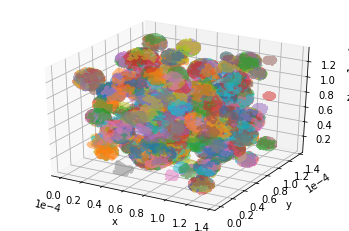

In [10]:
# Define substrate dictionary, run simulation, and show trajectories

substrate = {'type' : 'mesh',
             'mesh' : mesh,
             'intra' : True}  # Place spins only inside the mesh

n_s = int(1e3)
signals = simulations.simulation(n_s, diffusivity, gradient, dt, substrate,
                                 trajectories='example_traj.txt')

utils.show_traj('example_traj.txt')

If neither 'intra' or 'extra' are specified in the substrate dictionary like below, the initial positions of the random walkers are distributed uniformly across the voxel.

In [11]:
substrate = {'type' : 'mesh',
             'mesh' : mesh}

If you use Disimpy with the same GPU that runs your operating system's graphical user interface, this imposes restrictions on the maximum duration that a CUDA kernel call can take. In case of complicated geometries and/or long step lenghts, it is possible that the intersection check algorithm exceeds this limit, leading to a termination of the program. However, these problems should not occur with simple geometries for which Disimpy has primarily been developed for.

### A more interesting example

To illustrate the utility of Disimpy in more interesting scenarios than the trivial examples shown above, this example reproduces the diffraction pattern reported in Figure 2A in "Three-dimensional water diffusion in impermeable cylindrical tubes: theory versus experiments" by Avram et al. (https://doi.org/10.1002/nbm.1277). This example may take a few minutes or more to run depending on your GPU.

Starting simulation.
Step length = 6.954998416851478e-07
Number of spins = 100000
Number of steps = 9999
Simulation finished.


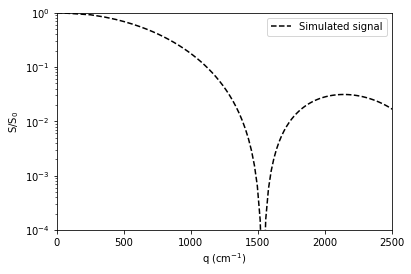

In [13]:
# A larger number of walkers and time points is required for convergence

n_s = int(1e5)  # Number of random walkers
n_t = int(1e4)  # Number of time points
substrate = {'type' : 'cylinder',
             'orientation' : np.array([0, 0, 1.0]),
             'radius' : 4.5e-6}


# Define gradient array with Δ = 400 ms, δ = 3 ms

bs = np.linspace(1, 1e12, 100)  # b-values in SI units
delta = 3e-3  # Gradient pulse duration in seconds
DELTA = 400e-3  # Diffusion time in seconds
T = DELTA + delta  # Duration of gradient array
gradient = np.zeros((1, 4030, 3))
gradient[0, 1:30, 0] = 1
gradient[0, 4000:4029, 0] = -1
gradient = np.concatenate([gradient for _ in bs], axis=0)
dt = T / (gradient.shape[1] - 1)
gradient, dt = gradients.interpolate_gradient(gradient, dt, n_t)
gradient = gradients.set_b(gradient, dt, bs)
delta = np.sum(gradient[-1, :, :] > 0) * dt
DELTA = np.min(np.where(gradient[-1, :, 0] < 0)) * dt
q = gradients.calc_q(gradient, dt)  # Calculate q-vectors
qs = np.max(np.linalg.norm(q, axis=2), axis=1)


# Run simulation

signals = simulations.simulation(n_s, diffusivity, gradient, dt, substrate)


# Plot signal decay showing the diffraction pattern at high values of q

fig, ax = plt.subplots(1, figsize=(6,4))
ax.plot(qs * 1e-2 / (2 * np.pi), signals/n_s, ls='--', color='black')
ax.legend(['Simulated signal'])
ax.set_xlabel('q (cm$^{-1}$)')
ax.set_ylabel('S/S$_0$')
ax.set_yscale('log')
ax.set_ylim([1e-4, 1])
ax.set_xlim([0, 2500])
plt.show()

### Advanced information

For details, please see [function documentation](https://disimpy.readthedocs.io/en/latest/modules_and_functions.html) and [source code](https://github.com/kerkelae/disimpy)